In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
import pickle
import xgboost as xgb
import plotly.express as px
from itertools import product


from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
def error_threshold(predicted_label, test_label, error_tolerance):
    '''Function to obtain predicted vectors with a certain amount of errors
    
    Args:
    predicted_label: list, predicted label
    test_label: list, true labels
    error_tolerance: int, number of errors allowed
    '''

    error = []
    error_vector = []

    for i,j in zip(predicted_label, test_label):
        if (i != j).any():
            error.append([i,j])

        if list(i == j).count(False) == error_tolerance:
            error_vector.append([i, j])
    
    return error, error_vector

def error_dataframe(predicted_label, test_label):
    '''Function to obtain a dataframe with the number of errors per sample

    Args:
    predicted_label: list, predicted label
    test_label: list, true labels
    '''
    df = pd.DataFrame(columns=['n_sample', 'n_errores'])
    
    k = 1
    for i, j in zip(predicted_label, test_label):
        n = list(i == j).count(False)
        df.loc[k] = [k,n]
        k += 1
    
    return df

In [2]:
# Load data using pickle

with open('data/variables.pkl', 'rb') as f:
    data = pickle.load(f)

normalized_vector = data[0]
label = data[1]

### Preparing train data

In [3]:
# Create train and test data
x_train, x_test, y_train, y_test = train_test_split(normalized_vector, label, test_size=0.3, random_state=0)

# Flatten the data
x_train_flat = np.array([np.concatenate(x) for x in x_train])
x_test_flat = np.array([np.concatenate(x) for x in x_test])

How it looks data

Text(0.5, 1.0, 'Flattened Data')

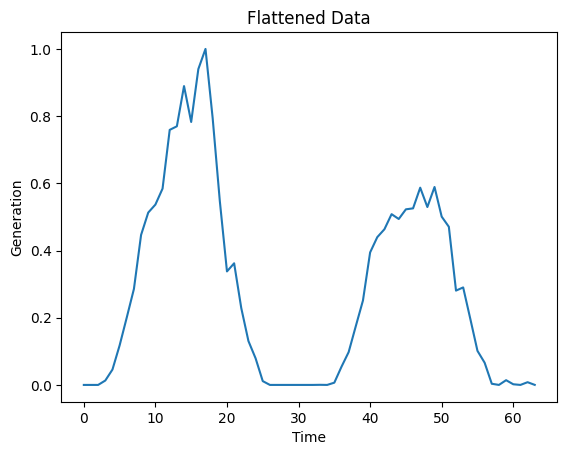

In [7]:
plt.plot(x_train_flat[10])
plt.xlabel('Time')
plt.ylabel('Generation')
plt.title('Flattened Data')

## Training XGBoost

In [ ]:
# Create an object DMatrix for the training data
dtrain = xgb.DMatrix(data = x_train_flat, label = y_train)

# Define model parameters
params = {
    "objective": "binary:logistic", 
    "learning_rate": 0.3
}

# Train the model
model = xgb.train(params, dtrain, 10000)

In [ ]:
# Save the model using pickle

with open('/model/XGBoost_10000.pkl'', 'wb') as f:
    pickle.dump(model, f)

In [4]:
# Load the model using pickle

with open('model/XGBoost_10000.pkl', 'rb') as f:
    model = pickle.load(f)

In [6]:
# Make predictions
dtest = xgb.DMatrix(data = x_test_flat)
y_pred_prob = model.predict(dtest)

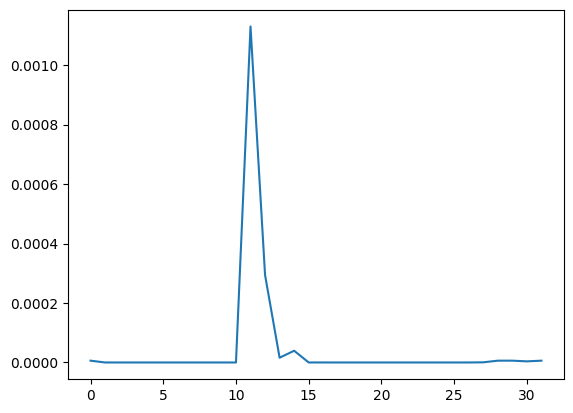

In [60]:
# Plot the predicted probability
plt.plot(y_pred_prob[17500])

Since the outputs are probability vectors, It's neccesary to look for the threshold that gives us the best performance

0.5236472945891785


Text(0.5, 1.0, 'Accuracy vs Error threshold')

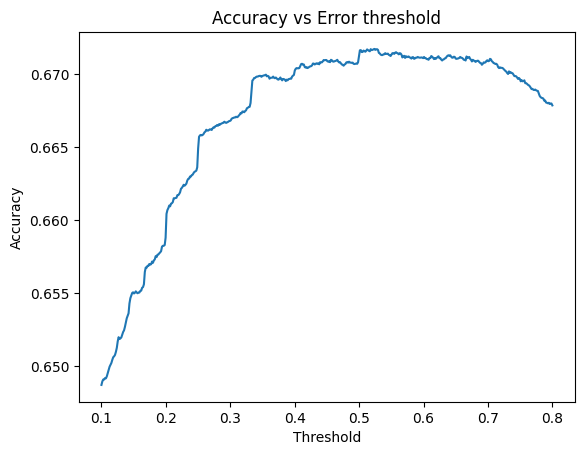

In [8]:
ummbral = np.linspace(0.1, 0.8, 500)
AC = []
for i in ummbral:
    y_pred = np.where(y_pred_prob >= i, 1, 0)
    accuracy = accuracy_score(y_test, y_pred)
    AC.append(accuracy)

idx_max = AC.index(max(AC))
print(ummbral[idx_max])

plt.plot(ummbral, AC)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Error threshold")

In [9]:
# Decision threshold
threshold = ummbral[idx_max]

# Convert probabilities to binary labels
'''If the probability is greater than the threshold, the label is 1, otherwise it is 0'''
y_pred = np.where(y_pred_prob >= threshold, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.6717193800709323


In [27]:
dataframe = error_dataframe(y_pred, y_test)

df = dataframe
df.loc[df['n_errores'] >= 5, 'n_errores'] = '5+'
error_counts = df['n_errores'].value_counts().reset_index()
error_counts.columns = ['n_errores', 'count']

fig = px.pie(error_counts, values='count', names='n_errores', title='number of errors per sample',
             width=600, height=500)
fig.update_layout(title_x=0.5)
fig.show()

In [31]:
error_counts['cumulative_count'] = error_counts['count'].cumsum()
total_errors = error_counts['count'].sum()
error_counts['cumulative_percent'] = (error_counts['cumulative_count'] / total_errors) * 100

fig = px.bar(error_counts, x='n_errores', y='cumulative_percent', title='Cumulative frequency',
             labels={'n_errores': 'Number of errors', 'cumulative_percent': 'Percentage (%)'},
             hover_data={'cumulative_count': True, 'cumulative_percent': ':.2f%'}, 
             width=600, height=500,
             color_discrete_sequence=['#2ca02c']
             )

fig.update_layout(title_x=0.5)
fig.update_traces(hovertemplate='Number of errors: %{customdata[0]}<extra></extra>')
fig.update_layout(bargap=0.4)
fig.show()

In order to explore a good model's performance, we look for the best parameter combination and repeat the same process as before, registering the accuracy.
Having done this, the results are shown in the next heatmap

There are certainly better ways to do it but since the model doesnt take too much training time, we can do this to explore its performance.


In [11]:
import time

In [12]:
lea_rate = np.linspace(0.3, 0.8, 6)
n_estimators = np.linspace(80, 400, 17).astype(int)

comb = list(product(lea_rate, n_estimators))

results = []
iteration_time = []
dtest = xgb.DMatrix(data = x_test_flat)
dtrain = xgb.DMatrix(data = x_train_flat, label = y_train)

ummbral = np.linspace(0.1, 0.8, 80)


for j in comb:
    iteration_start_time = time.time()
    params = {
        "objective": "binary:logistic", 
        "learning_rate": j[0]
    }

    # Train the model
    model = xgb.train(params, dtrain, j[1])

    y_pred_prob = model.predict(dtest)
    AC = []
    for i in ummbral:
        y_pred = np.where(y_pred_prob >= i, 1, 0)
        accuracy = accuracy_score(y_test, y_pred)
        AC.append(accuracy)
    idx_max = AC.index(max(AC))
    threshold = ummbral[idx_max]

    y_pred = np.where(y_pred_prob >= threshold, 1, 0)
    accuracy = accuracy_score(y_test, y_pred)
    results.append([j[0], j[1], accuracy])
    print(j[0], j[1], accuracy)

    iteration_end_time = time.time()
    elapsed_time = iteration_end_time - iteration_start_time
    iteration_time.append(elapsed_time)
    print(f"Elapsed time: {elapsed_time}")


0.3 80 0.631589175533207
Elapsed time: 95.87844204902649
0.3 100 0.638342321333139
Elapsed time: 111.6442301273346
0.3 120 0.6421804401690716
Elapsed time: 128.90071058273315
0.3 140 0.6453059968582487
Elapsed time: 143.8234839439392
0.3 160 0.6471197914136261
Elapsed time: 161.3662269115448
0.3 180 0.64961375892727
Elapsed time: 179.0407111644745
0.3 200 0.6517838345560252
Elapsed time: 199.50846529006958
0.3 220 0.6542939966639136
Elapsed time: 216.69025659561157
0.3 240 0.6548284182739802
Elapsed time: 234.91823530197144
0.3 260 0.6560592074365577
Elapsed time: 254.65882539749146
0.3 280 0.6566422128293575
Elapsed time: 271.22026777267456
0.3 300 0.6564316831041799
Elapsed time: 289.39598870277405
0.3 320 0.6574357479473352
Elapsed time: 310.0600075721741
0.3 340 0.6583750344135127
Elapsed time: 326.7226297855377
0.3 360 0.6585693695444461
Elapsed time: 343.0340270996094
0.3 380 0.6598163533012681
Elapsed time: 363.1863443851471
0.3 400 0.6602050235631346
Elapsed time: 379.327583074

In [13]:
df = pd.DataFrame(results, columns=['X', 'Y', 'Value'])

fig = px.imshow(df.pivot_table(index='Y', columns='X', values='Value'),
                labels=dict(x="X", y="Y", color="Value"),
                x=df['X'].unique(),
                y=df['Y'].unique(),
                color_continuous_scale='Viridis',
                width=600, 
                height=600)

fig.update_xaxes(type='category')

This graph allows us to observe how the model's accuracy improves based on the learning rate and the number of estimators. This will be a good starting point for future testing